# Vep assessment breakdown

Analysis done to check the contribution of each vep assessment score for lead variants in credible sets

## Methods

In [ ]:
from __future__ import annotations

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns


In [ ]:
# Set default figure theme
sns.set_theme(
    context="paper",
    palette=sns.color_palette(["darkred", "darkorange", "black", "lightgreen"]),
    style="whitegrid",
)


def adjust_study_type(study_type: pl.Expr) -> pl.Expr:
    """Adjust study type based on qtl distance type."""
    qtl_distance_type = (
        pl.when(pl.col("isTransQtl"))
        .then(pl.lit("trans"))
        .when(~pl.col("isTransQtl"))
        .then(pl.lit("cis"))
        .otherwise(pl.lit(None))
    )
    adjusted_study_type = (
        pl.when(study_type == "pqtl")
        .then(pl.concat_str(qtl_distance_type, study_type, separator="-"))
        .otherwise(study_type)
        .alias("studyType")
    )
    return adjusted_study_type


class VepScoringGroup:
    def __init__(self, score: str, label: str):
        assert isinstance(score, (int, float)), "Score must be a number"
        assert isinstance(label, str), "Label must be a string"
        self.score = score
        self.label = label

    def __gt__(self, other: VepScoringGroup) -> bool:
        return self.score > other.score

    def __lt__(self, other: VepScoringGroup) -> bool:
        return self.score < other.score

    def __eq__(self, other: VepScoringGroup) -> bool:
        return self.score == other.score


def classify_by_vep_score(effect: pl.Expr, scores: list[VepScoringGroup] | None = None) -> pl.Expr:
    """Classify the vep score by given scores."""
    if not scores:
        scores = [
            VepScoringGroup(score=0.0, label="very low"),
            VepScoringGroup(score=0.1, label="low"),
            VepScoringGroup(score=0.33, label="medium"),
            VepScoringGroup(score=0.66, label="high"),
            VepScoringGroup(score=1.0, label="very high"),
        ]
    expr = pl.when(False).then(None)
    groups = sorted(scores, reverse=True)
    for group in groups:
        expr = expr.when(effect.struct.field("normalisedScore") >= group.score).then(pl.lit(group.label))
    expr = expr.otherwise(pl.lit(None)).alias("vepScoreClass")
    return expr


## Dataset loading

In [ ]:
dataset = pl.read_parquet("../../data/rescaled-betas.parquet")


In [19]:
df = dataset.select(
    pl.col("vepEffect").struct.unnest(),
    classify_by_vep_score(pl.col("vepEffect")),
    adjust_study_type(pl.col("studyType")),
    pl.col("finemappingMethod"),
)


In [56]:
data = (
    df.with_columns(
        cat=pl.concat_str(pl.col("studyType"), pl.col("finemappingMethod"), separator=" - "), ones=pl.lit(1)
    )
    .group_by("cat", "assessment")
    .agg(pl.sum("ones"), pl.first("normalisedScore"), pl.first("vepScoreClass"))
    .sort("ones")
    .pivot(
        on=["cat"],
        index=["assessment", "normalisedScore", "vepScoreClass"],
        values=["ones"],
        aggregate_function="sum",
    )
    # .fill_null(0)
).sort("normalisedScore", "assessment", descending=True, maintain_order=True)

ordered_cols = sorted([c for c in data.columns if " - " in c])
new_names = [f"% {c}" for c in ordered_cols]
print(ordered_cols)
percent = [(pl.col(old) / pl.sum(old) * pl.lit(100)).alias(new) for old, new in zip(ordered_cols, new_names)]
ordered_groups = ["very low", "low", "medium", "high", "very high"]
data = data.select("assessment", *ordered_cols, *percent, "normalisedScore", "vepScoreClass")
data = data.to_pandas()
assessment_order = data["assessment"]
data


['cis-pqtl - SuSiE-inf', 'cis-pqtl - SuSie', 'eqtl - SuSie', 'gwas - PICS', 'gwas - SuSiE-inf', 'gwas - SuSie', 'sceqtl - SuSie', 'sqtl - SuSie', 'trans-pqtl - SuSiE-inf', 'tuqtl - SuSie']


,assessment,cis-pqtl - SuSiE-inf,cis-pqtl - SuSie,eqtl - SuSie,gwas - PICS,gwas - SuSiE-inf,gwas - SuSie,sceqtl - SuSie,sqtl - SuSie,trans-pqtl - SuSiE-inf,...,% eqtl - SuSie,% gwas - PICS,% gwas - SuSiE-inf,% gwas - SuSie,% sceqtl - SuSie,% sqtl - SuSie,% trans-pqtl - SuSiE-inf,% tuqtl - SuSie,normalisedScore,vepScoreClass
0,stop_lost,4.0,NaN,36,18.0,2.0,NaN,1.0,2.0,2.0,...,0.002667,0.008985,0.000563,NaN,0.001896,0.000895,0.011312,0.003117,1.00,very high
1,stop_gained,40.0,NaN,678,475.0,503.0,55.0,28.0,60.0,98.0,...,0.050233,0.237111,0.141535,0.265649,0.053085,0.026845,0.554299,0.040526,1.00,very high
2,start_lost,5.0,1.0,19,34.0,7.0,NaN,NaN,2.0,1.0,...,0.001408,0.016972,0.001970,NaN,NaN,0.000895,0.005656,0.006235,1.00,very high
3,splice_donor_variant,15.0,2.0,1880,126.0,318.0,8.0,42.0,478.0,11.0,...,0.139290,0.062897,0.089479,0.038640,0.079627,0.213864,0.062217,0.112746,1.00,very high
4,splice_acceptor_variant,9.0,2.0,728,94.0,33.0,2.0,8.0,446.0,3.0,...,0.053938,0.046923,0.009286,0.009660,0.015167,0.199546,0.016968,0.068583,1.00,very high
5,frameshift_variant,27.0,2.0,647,468.0,92.0,64.0,4.0,130.0,32.0,...,0.047937,0.233617,0.025887,0.309119,0.007584,0.058164,0.180995,0.047280,1.00,very high
6,splice_donor_5th_base_variant,11.0,NaN,1579,36.0,450.0,7.0,26.0,494.0,24.0,...,0.116989,0.017971,0.126622,0.033810,0.049293,0.221022,0.135747,0.098717,0.66,high
7,protein_altering_variant,NaN,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,...,0.001408,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.66,high
8,missense_variant,1200.0,185.0,23155,14145.0,20633.0,1085.0,613.0,6734.0,2076.0,...,1.715566,7.060920,5.805751,5.240533,1.162173,3.012881,11.742081,2.689531,0.66,high
9,inframe_insertion,2.0,2.0,564,13.0,20.0,4.0,42.0,123.0,9.0,...,0.041787,0.006489,0.005628,0.019320,0.079627,0.055032,0.050905,0.016366,0.66,high


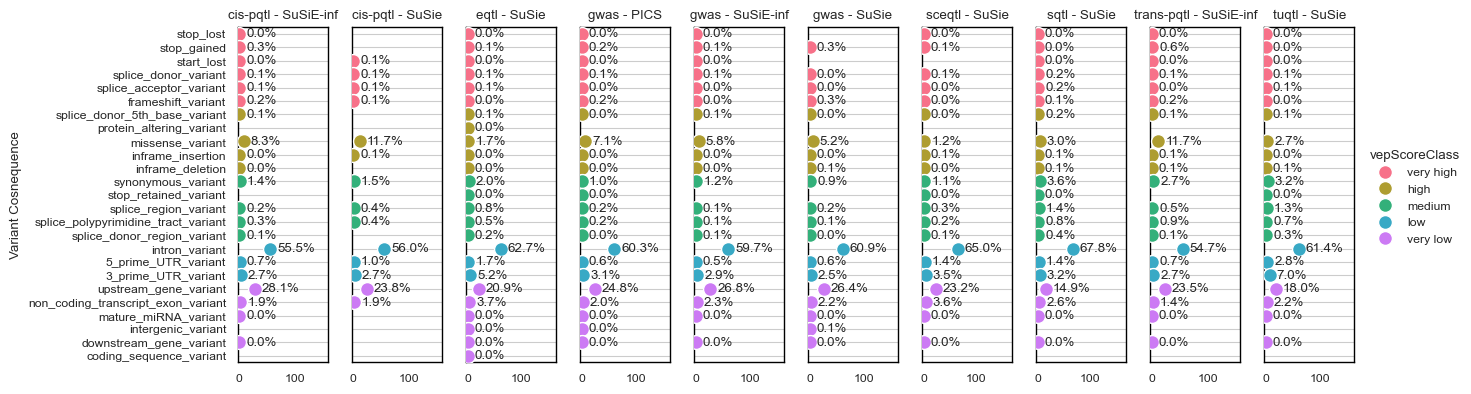

In [57]:
g = sns.PairGrid(
    data,
    y_vars=["assessment"],
    x_vars=new_names,
    hue="vepScoreClass",
    aspect=0.3,
    height=4,
    dropna=True,
)
g.map(
    sns.stripplot,
    size=10,
    orient="h",
    jitter=True,
    palette="flare_r",
    linewidth=1,
    edgecolor="w",
    order=assessment_order,
)
g.set(ylabel="Variant Cosnequence")
# g.map(plt.pie(x))

titles = [c for c in data.columns if " - " in c]

for ax, title in zip(g.axes.flat, titles):
    # Set a different title for each axes
    ax.set(title=title)

    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(False)
    ax.yaxis.grid(True)
    ax.set_xlabel(None)

    for collection in ax.collections:
        offsets = collection.get_offsets()
        for x, y in offsets:
            x_lim_1 = ax.get_xlim()[1]
            ax.annotate(
                f"{round(x, 1):.1f}%", xy=(x, y), xytext=(5, 0), textcoords="offset points", ha="left", va="center"
            )
    x_lim = ax.get_xlim()
    ax.set_xlim((x_lim[0], x_lim[1] + 100))

sns.despine(left=True, bottom=True)

for ax in g.axes.flatten():  # Loop directly on the flattened axes
    for _, spine in ax.spines.items():
        spine.set_visible(True)  # You have to first turn them on
        spine.set_color("black")
        spine.set_linewidth(1)
    ax.set_facecolor((0, 0, 0, 0))  # Set the axes background to be transparent


g.add_legend()

g.figure.patch.set_alpha(0)  # Set the figure background to be transparent
plt.show()
